In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [4]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [5]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [6]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
# YOUR CODE HERE!

In [7]:
Return = yen_futures['Settle'].pct_change()*100
yen_futures['Return'] = Return.copy()
yen_futures = yen_futures.dropna()
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509


In [8]:
yen_futures.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1415 entries, 2014-02-18 to 2019-10-15
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Open                        1415 non-null   float64
 1   High                        1415 non-null   float64
 2   Low                         1415 non-null   float64
 3   Last                        1415 non-null   float64
 4   Change                      1415 non-null   float64
 5   Settle                      1415 non-null   float64
 6   Volume                      1415 non-null   float64
 7   Previous Day Open Interest  1415 non-null   float64
 8   Return                      1415 non-null   float64
dtypes: float64(9)
memory usage: 110.5 KB


In [9]:
# Create a lagged return using the shift function
yen_futures['Lagget_Return']= Return.shift()
yen_futures = yen_futures.dropna()
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagget_Return
Date,,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304,-0.369458
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335,-0.564304
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509,0.151335


In [10]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2017']
test = yen_futures['2018':]

In [11]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
# YOUR CODE HERE!

In [12]:
X_train = train['Lagget_Return'].to_frame()
X_train

,Lagget_Return
Date,
2014-02-18,0.409123
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604
...,...
2017-12-22,0.084621
2017-12-26,0.118370
2017-12-27,0.118230


### Train Test Split

In [13]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_test = test['Lagget_Return'].to_frame()
y_train = train['Return']
y_test = test['Return']

# Linear Regression Model

In [14]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [15]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [16]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results['predctions'] = predictions

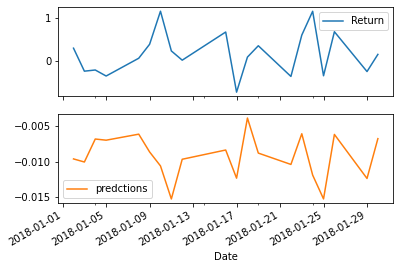

In [17]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True);

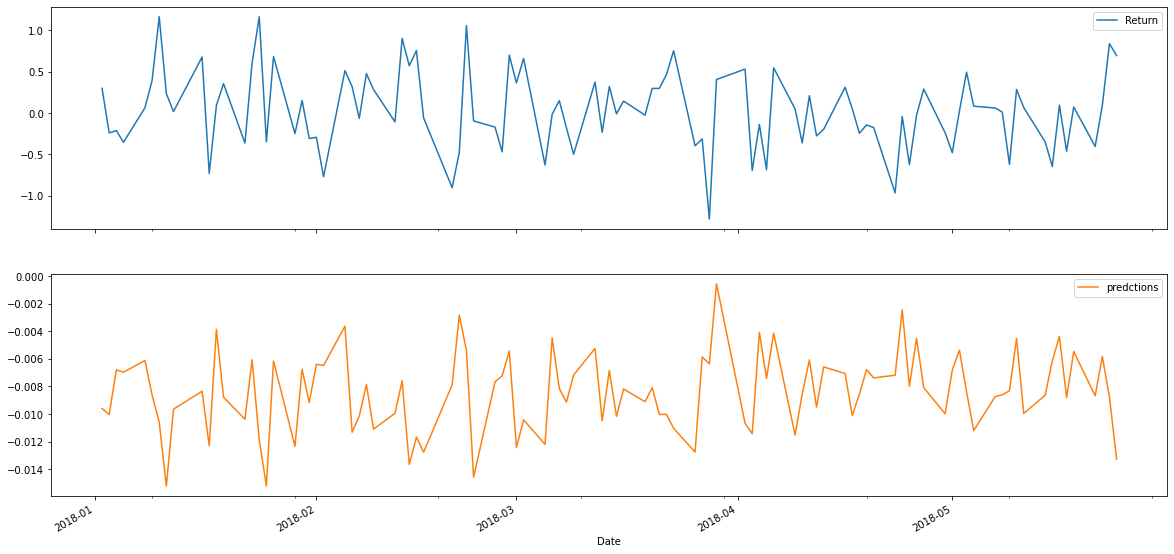

In [19]:
# Plot the first 20 predictions vs the true values
Results[:100].plot(subplots=True, figsize = (20,10));

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [21]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(Results['Return'],Results['predctions'])

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
out_of_sample_rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.41545437184712763


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [22]:
# Construct a dataframe using just the "y" training data:
in_sample = model.predict(X_train)

# Add a column of "in-sample" predictions to that dataframe:  
Results2 = y_train.to_frame()
Results2['in_sample'] = in_sample

from sklearn.metrics import mean_squared_error
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
mse2 = mean_squared_error(Results2['Return'],Results2['in_sample'])

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse2 = np.sqrt(mse2)
print(f"in_sample Root Mean Squared Error (RMSE): {in_sample_rmse2}")

in_sample Root Mean Squared Error (RMSE): 0.5962037920929946


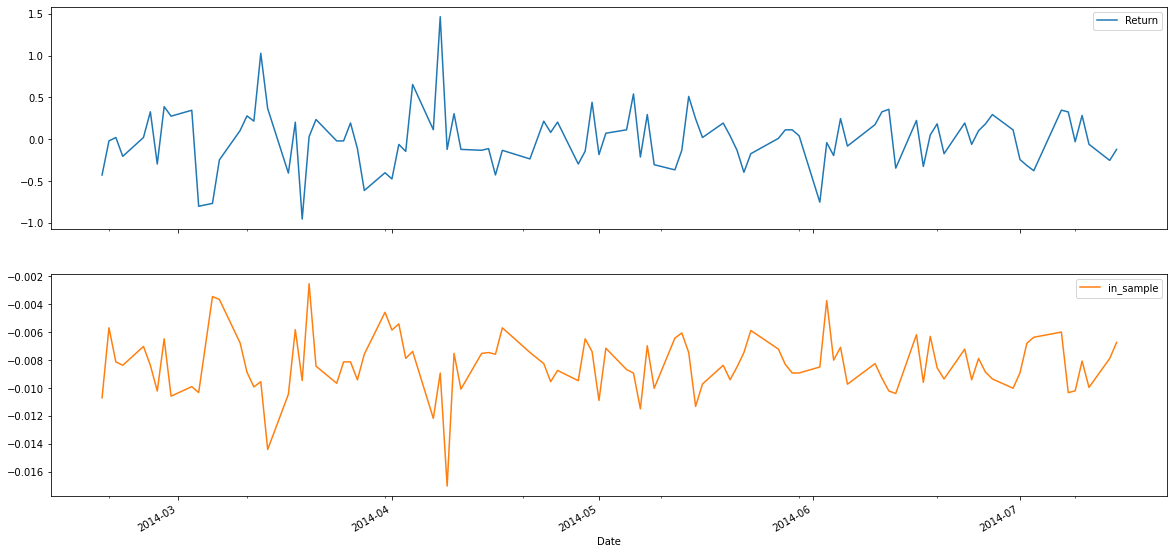

In [23]:
# Plot the first 20 in_sample vs the true values
Results2[:100].plot(subplots=True, figsize=(20,10));

# Conclusions

YOUR CONCLUSIONS HERE!

The SKLearn linear regression model did not predict Yen futures ("settle") returns.The prediction model fail in predicting Return Price and Price behavior. The reason this happened was because the small amount of Test Data. The Size of amount of data training and data test is disproportionated.By changing the data feeded into the model ( Create a train/test split for the data train = yen_futures[:'2016'], test = yen_futures['2018':] ) for a more proportional one  I could find a better match for price behavior but still the model couldn’t predict the Return Price.


Please, refer to a regresion_analysis3.ipynb, for code and results.



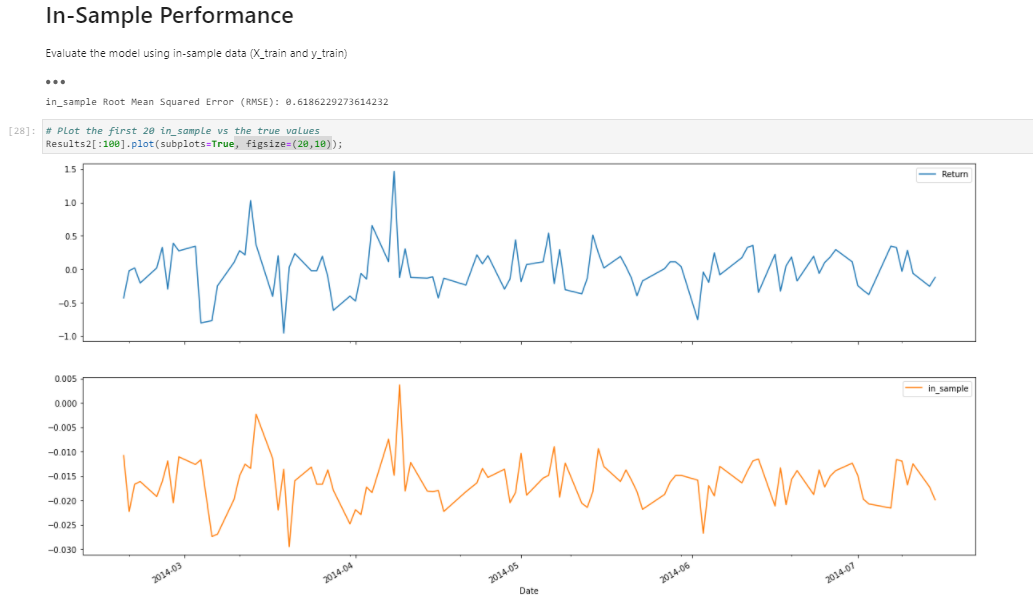

* in_sample Root Mean Squared Error (RMSE): 0.5962037920929946
* Out-of-Sample Root Mean Squared Error (RMSE): 0.41545437184712763, 
This values are smaller than the spected for a Good Prediction Model of >=0.8.